# Comparing local and distributed batch training

Using this notebook to compare two training configurations with same global batch size:
- all on one device
- distributed across devices with DDP and gradient reductions

The potential issue here is that the gradient averaging can be biased in the distributed case when samples are different sizes.

In [1]:
%pwd

'/global/u2/s/sfarrell/WorkAreas/trackml/heptrkx-gnn-tracking/notebooks'

In [2]:
# System imports
import os
import sys
import pprint

# External imports
import matplotlib.pyplot as plt
import numpy as np

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from trainers import get_trainer
from nb_utils import (load_config_file, load_config_dir, load_summaries,
                      plot_train_history, get_test_data_loader,
                      compute_metrics, plot_metrics, draw_sample_xy)

In [3]:
%matplotlib inline

In [4]:
plt.rcParams['font.size'] = '14'

## Load training results

Specify which results to load either by config file or training output directory.

In [5]:
# Load by directory (preferred)
result_base = os.path.expandvars('$SCRATCH/heptrkx/results')

In [6]:
ls $result_base

RNNFilter_20180207_1121/  gnnsegclf_med_011/    mpnn_big_008/
agnn_000/                 gnnsegclf_small_000/  mpnn_med_000/
agnn_001/                 gnnsegclf_small_001/  mpnn_med_001/
agnn_002/                 gnnsegclf_small_002/  resepnn_big_001/
agnn_002_8gpu/            gnnsparse_big_001/    resepnn_big_003/
agnn_big_000/             gnnsparse_med_001/    resmpnn_001/
agnn_big_001/             hello/                resmpnn_002/
agnn_big_002/             mpnn_001/             resmpnn_002a/
agnn_scaling/             mpnn_002/             resmpnn_002b/
gnnsegclf_000/            mpnn_batch/           resmpnn_002c/
gnnsegclf_001/            mpnn_big_000/         resmpnn_big_000/
gnnsegclf_004/            mpnn_big_001/         resmpnn_big_001/
gnnsegclf_big_000/        mpnn_big_002/         resmpnn_big_002/
gnnsegclf_big_002/        mpnn_big_003/         resmpnn_big_003/
gnnsegclf_big_003/        mpnn_big_004/         stable_big_001/
gnnsegclf_med_000/        mpnn_big_005/         temp

In [7]:
# Non-distributed, baseline results
result_name = 'resmpnn_002'
result_dir = os.path.join(result_base, result_name)
config = load_config_dir(result_dir)
summaries = load_summaries(config)

In [8]:
# Distributed results
result_name = 'resmpnn_002a'
result_dir = os.path.join(result_base, result_name)
dist1_config = load_config_dir(result_dir)
dist1_summaries = load_summaries(dist1_config)

In [9]:
# Distributed results
result_name = 'resmpnn_002b'
result_dir = os.path.join(result_base, result_name)
dist2_config = load_config_dir(result_dir)
dist2_summaries = load_summaries(dist2_config)

In [10]:
# Distributed results
result_name = 'resmpnn_002c'
result_dir = os.path.join(result_base, result_name)
dist3_config = load_config_dir(result_dir)
dist3_summaries = load_summaries(dist3_config)

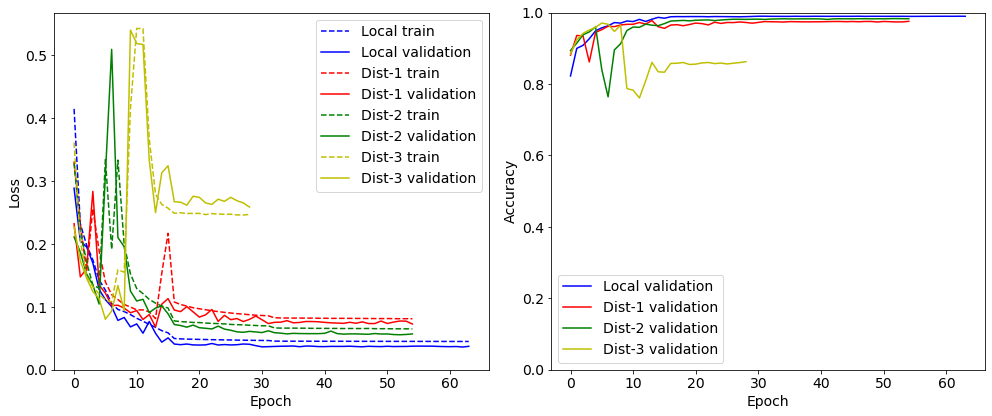

In [11]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(14, 6))

# Plot losses
ax0.plot(summaries.epoch, summaries.train_loss, 'b--', label='Local train')
ax0.plot(summaries.epoch, summaries.valid_loss, 'b-', label='Local validation')
ax0.plot(dist1_summaries.epoch, dist1_summaries.train_loss, 'r--', label='Dist-1 train')
ax0.plot(dist1_summaries.epoch, dist1_summaries.valid_loss, 'r-', label='Dist-1 validation')
ax0.plot(dist2_summaries.epoch, dist2_summaries.train_loss, 'g--', label='Dist-2 train')
ax0.plot(dist2_summaries.epoch, dist2_summaries.valid_loss, 'g-', label='Dist-2 validation')
ax0.plot(dist3_summaries.epoch, dist3_summaries.train_loss, 'y--', label='Dist-3 train')
ax0.plot(dist3_summaries.epoch, dist3_summaries.valid_loss, 'y-', label='Dist-3 validation')
ax0.set_xlabel('Epoch')
ax0.set_ylabel('Loss')
ax0.set_ylim(bottom=0)
#ax0.set_yscale('log')
ax0.legend(loc=0)

# Plot accuracies
ax1.plot(summaries.epoch, summaries.valid_acc, 'b-', label='Local validation')
ax1.plot(dist1_summaries.epoch, dist1_summaries.valid_acc, 'r-', label='Dist-1 validation')
ax1.plot(dist2_summaries.epoch, dist2_summaries.valid_acc, 'g-', label='Dist-2 validation')
ax1.plot(dist3_summaries.epoch, dist3_summaries.valid_acc, 'y-', label='Dist-3 validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(bottom=0, top=1)
ax1.legend(loc=0)

plt.tight_layout()

In the above plot, we train the same model configuration in multiple ways:
* **Local**: Single GPU with batch size 4
* **Dist-1**: Distributed training on 4 GPUs, local batch size 1, total batch size 4
* **Dist-2**: Rerun of Dist-1, exact same setup
* **Dist-3**: Distributed training on 4 GPUs, local batch size 1, but with local loss weighted to reproduce same gradient averaging as "local" setup

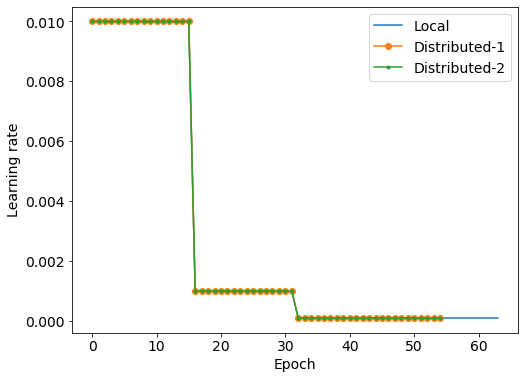

In [12]:
# Confirm that the same learning rates were used
plt.figure(figsize=(8,6))
plt.plot(summaries.lr, label='Local')
plt.plot(dist1_summaries.lr, 'o-', label='Distributed-1')
plt.plot(dist2_summaries.lr, '.-', label='Distributed-2')
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.legend(loc=0);

## Discussion

Here we used our most powerful model (resmpnn) with batch size 4 and compared single-gpu training with 4-gpu training.

The distributed training in this case is shown to be less stable and struggles to converge compared to the single node training.

My attempt to fix this by appropriately weighting the local loss so the average gradients should be the same as the 1gpu case didn't seem to fix the issue. In fact, this training run had the worst results. Perhaps I made a mistake.